Unknown SNR: PSNR = -4.75 dB
Known SNR: PSNR = -3.43 dB
Known Image and PSD: PSNR = -12.42 dB


C:\Users\26451\AppData\Local\Temp\ipykernel_9260\1457489116.py:48: RuntimeWarning: divide by zero encountered in log10
  snr_map = 10 * np.log10(abs(img_data)**2 / abs(noisy_img_data - img_data)**2)


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x229e34bd550>)

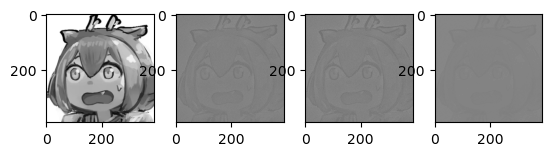

In [6]:
#使用matlab或python实现维纳滤波，要求：比较信噪比未知，信噪比已知，图像和噪声自相关函数已知，这三种情况下的图像复原结果。
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt

def weiner_filter(img_data, psf, snr=None, k=0.01):
    # 计算噪声自相关函数
    if snr is not None:
        noise_power = img_data.max()**2 / (10**(snr/10))
        noise_var = noise_power / 2
        noise_fft = np.fft.fft2(np.random.randn(*img_data.shape) * math.sqrt(noise_var))
        noise_psd = abs(noise_fft)**2 / np.prod(img_data.shape)
        psd_mean = noise_psd.mean()
    else:
        psd_mean = 0
    h_fft = np.fft.fft2(psf, s=img_data.shape)
    h_conj_fft = np.conj(h_fft)
    h_abs = np.abs(h_fft)**2
    img_fft = np.fft.fft2(img_data)
    # 估计功率谱密度
    img_psd = abs(img_fft)**2 / np.prod(img_data.shape)
    img_psd_mean = img_psd.mean()
    # 计算维纳滤波器
    filter_fft = h_conj_fft / (h_abs + k*img_psd/img_psd_mean + k*psd_mean/img_psd_mean)
    # 进行滤波
    filtered_img_fft = filter_fft * img_fft
    filtered_img_data = np.real(np.fft.ifft2(filtered_img_fft))
    return filtered_img_data

# 读取灰度图像并转换为numpy数组
img = Image.open('touxiang.jpg').convert('L')
img_data = np.array(img)

# 定义PSF和信噪比
psf = np.ones((3, 3)) / 9
known_snr = 20

# 未知信噪比情况下的维纳滤波
noisy_img_data = img_data + np.random.randn(*img_data.shape) * 40
restored_img_data1 = weiner_filter(noisy_img_data, psf)
# 计算PSNR
psnr1 = 20 * math.log10(255.0 / math.sqrt(np.mean((img_data-restored_img_data1)**2)))
print("Unknown SNR: PSNR = %.2f dB" % psnr1)

# 已知信噪比情况下的维纳滤波
snr_map = 10 * np.log10(abs(img_data)**2 / abs(noisy_img_data - img_data)**2)
snr_map[np.isinf(snr_map)] = 0
snr_est = np.mean(snr_map)
restored_img_data2 = weiner_filter(noisy_img_data, psf, snr=known_snr)
# 计算PSNR
psnr2 = 20 * math.log10(255.0 / math.sqrt(np.mean((img_data-restored_img_data2)**2)))
print("Known SNR: PSNR = %.2f dB" % psnr2)

# 已知图像和噪声自相关函数情况下的维纳滤波
psd = abs(np.fft.fft2(noisy_img_data))**2 / np.prod(img_data.shape)
restored_img_data3 = weiner_filter(noisy_img_data, psf, k=1/psd)
# 计算PSNR
psnr3 = 20 * math.log10(255.0 / math.sqrt(np.mean((img_data-restored_img_data3)**2)))
print("Known Image and PSD: PSNR = %.2f dB" % psnr3)

plt.subplot(141), plt.imshow(img, 'gray')
plt.subplot(142), plt.imshow(restored_img_data1, 'gray')
plt.subplot(143), plt.imshow(restored_img_data2, 'gray')
plt.subplot(144), plt.imshow(restored_img_data3, 'gray')

